In [68]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import os, os.path
import cv2
import skimage.feature

In [4]:
def getDataGTSDB(rootpath):
    data = []
    gtFile = open(rootpath)
    gtReader = csv.reader(gtFile, delimiter=';')
    data = []
    for row in gtReader:
        data.append(row)
    gtFile.close()        
    return data

In [5]:
#determine number of unique images with some amount of labeling
#determine number of images with single label vs more than one

data = getDataGTSDB('./FullIJCNN2013/gt.txt')
current = data[0][0]
duplicate = False
nunique = 1
nsingle = 0
for row in data[1:]:
    if current == row[0]:
        if duplicate is False:
            duplicate = True
    else:
        current = row[0]
        if duplicate is False:
            nunique += 1
            nsingle += 1
        else:
            nunique += 1
        duplicate = False

In [6]:
print(nunique)
print(nsingle)

741
395


In [7]:
data = np.array(data)
filenames = data[:,0]
len(np.unique(filenames))

741

In [28]:
#determine how many sign instances are in the topten (for end to end testing, bottleneck restricted by 
#classification capacity which we know is topten (ML methods I use are very sensitive to data skew)
#so this will tell us how many images we can actually use to end to end test final product

count = 0
topten = [2, 1, 13, 12, 38, 10, 4, 5, 25, 9]
index_map = {}
for i, sign in enumerate(topten):
    index_map[sign] = i
    
counts = [0]*len(topten)

for row in data:
    if int(row[5]) in topten:
        count += 1
        counts[index_map[int(row[5])]] += 1
        
print(count)
print(counts)

#there are 689 topten signs out of 1,213 instances, 
#roughly reflects the ratio in the GTSRB training and test sets

689
[81, 79, 83, 85, 88, 80, 68, 53, 31, 41]


In [9]:
#determine distribution that i should use to generate easy positives
summand = sum(counts)
distribution = [int(num*10000/summand) for num in counts]
print(distribution)

[1175, 1146, 1204, 1233, 1277, 1161, 986, 769, 449, 595]


In [10]:
def getDimensionsGTSRB(rootpath):
    widths = []
    heights = []
    # loop over all 43 classes
    for c in range(0,43):
        prefix = rootpath + '/Images/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.__next__() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            #images.append(plt.imread(prefix + row[0])) # the 1st column is the filename
            widths.append(int(row[1]))
            heights.append(int(row[2]))
        gtFile.close()
    return (widths, heights)
    
def getDimensionsGTSDB(rootpath):
    widths = []
    heights = []
    gtFile = open(rootpath)
    gtReader = csv.reader(gtFile, delimiter=';')
    data = []
    for row in gtReader:
        widths.append(int(row[3]) - int(row[1]))
        heights.append(int(row[4]) - int(row[2]))
    gtFile.close()        
    return (widths, heights)

In [161]:
#examine distribution of sign dimensions from GTSDB
widths, heights = getDimensionsGTSDB('./FullIJCNN2013/gt.txt')
widths = np.array(widths)
heights = np.array(heights)
aspect = widths / heights

print(len(widths), len(heights)) #both should be 1213
print(min(aspect), max(aspect))
print(min(widths), min(heights)) #shoud be no smaller than 16 x 16
print(max(widths), max(heights)) #should be no larger than 128 x 128

1213 1213
0.5862068965517241 1.2666666666666666
16 16
127 128


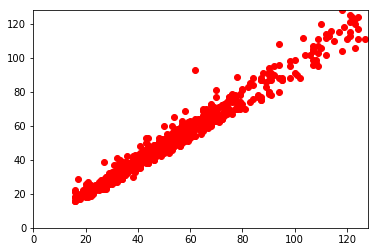

In [162]:
plt.plot(widths, heights, 'ro')
plt.axis([0, 128, 0, 128])
plt.show()

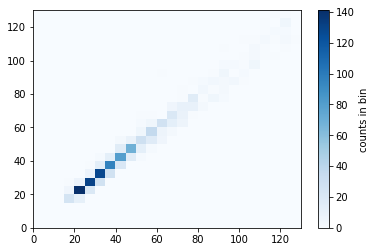

In [164]:
#use pyplots 2D hist to visualize densities and extract them appropriately
#here I use 10 by 10 pixel bins
plt.hist2d(widths, heights, bins=26, range=[[0,130],[0,130]], cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

In [11]:
#examine distribution of sign dimensions from training recognition data
(widths, heights) = getDimensionsGTSRB('./GTSRB/Final_Training')
print(len(widths), len(heights)) #should be 39,209
print(min(widths), min(heights)) #should be no smaller than 15 x 15
print(max(widths), max(heights)) #should be no larger than 250 x 250

39209 39209
25 25
243 225


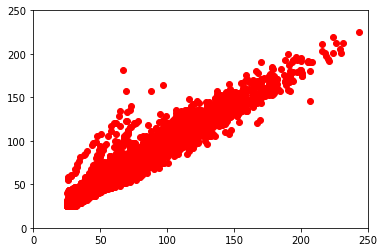

In [12]:
#plot distribution of sign dimensions from training recognition data
plt.plot(widths, heights, 'ro')
plt.axis([0, 250, 0, 250])
plt.show()

In [13]:
#see how much data we have if we restrict to size of detection signs, and aspect ratio closely square?
count = 0
w_restricted = []
h_restricted = []
for i in range(0,len(widths)):
    aspect = widths[i] / heights[i]
    if aspect >= 0.58 and aspect <= 1.266:
        if widths[i] < 128 and heights[i] < 128:
            w_restricted.append(widths[i])
            h_restricted.append(heights[i])
            count += 1
print(count)

38323


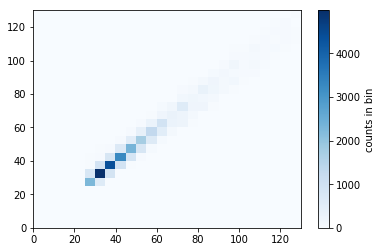

In [14]:
#use pyplots 2D hist to visualize densities and extract them appropriately
#here I use 10 by 10 pixel bins
plt.hist2d(widths, heights, bins=26, range=[[0,130],[0,130]], cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

In [15]:
#extract the counts only, and convert to probabilities, for negative bounding box generation
#note that widths are histogramed along the vertical axis, and heights along the horizontal axes
counts, xedges, yedges = np.histogram2d(widths, heights, bins=25, range=[[0,250],[0,250]])
print(counts.shape)

(25, 25)


In [16]:
counts = counts / sum(sum(counts)) #convert to probabilities
print(np.min(counts)) #should be >= 0
print(np.max(counts)) #should be <= 1
print(np.sum(counts)) #should be = 1

0.0
0.2842969726338341
1.0


In [17]:
#match appropriate center x,y coordinate with computed bin probabilities
prob = []
for i in range(0,len(counts)):
    for j in range(0,len(counts[0])):
        prob.append([((i+1)*10 - 5, (j+1)*10 - 5), counts[i,j]])

In [18]:
for (coord,proba) in prob:
    if proba > 0.28:
        print(coord)

(35, 35)


In [19]:
sizes = []
probs = []
for (coord,proba) in prob:
    sizes.append(str(coord[0]) + ":" + str(coord[1]))
    probs.append(proba)
print(len(sizes),len(probs))
print(sizes[np.argmax(probs)])

625 625
35:35


In [20]:
def readTrafficSigns(rootpath):    
    images = [] # images
    counts = []
    # loop over all 42 classes
    for c in range(0,43):
        subfolder = rootpath + '/' + format(c, '02d') # subdirectory for class
        path, dirs, files = os.walk(subfolder).__next__()
        for i in range(0,6000):
            images.append(plt.imread(subfolder + '/'+ format(i, '05d') + '.ppm')) # annotations file
        counts.append(len(files))
    return images

In [21]:
#Harvest postitive samples of traffic sign images

#get 6,000 random positive class images from GTSRB Test Set
images1 = []
path = './GTSRB/Final_Testing/Images'
for i in range(0,6000):
    images1.append(plt.imread(path + '/'+ format(i, '05d') + '.ppm')) # annotations file
len(images1)

6000

In [22]:
def getPositiveTrainImages(rootpath, distribution):    
    images = [] # feature vectors
    labels = [] # corresponding labels
    count = 0
    # loop over topten classes
    for c in topten:
        print(c)
        temp = []
        subfolder = rootpath + format(c, '05d') # subdirectory for class
        path, dirs, files = os.walk(subfolder).__next__()
        for file in files:
            if file[-3:] != 'csv':
                temp.append(plt.imread(subfolder + '/' + file)) # annotations file
            
        #randomize before selection since images ordered in some manner based on similarity
        indexes = [i for i in range(0,len(temp))]
        np.random.shuffle(indexes)
        temp = np.array(temp) 
        crop = temp[indexes][0:distribution[index_map[c]]]
        images.extend(crop)
        labels.extend([c]*len(crop))

    return images, labels

In [24]:
#Harvest postitive samples of topten traffic sign images
#distribution = [1175, 1146, 1204, 1233, 1277, 1161, 986, 769, 449, 595]

#get 10,000 topten positive class images from GTSRB Training Set
path = './GTSRB/Final_Training/Images/'
easy_pos, easy_pos_label = getPositiveTrainImages(path, distribution)
print(len(easy_pos))

9995


In [25]:
sum(distribution)

9995

In [26]:
print(len(easy_pos_label))
print(len(easy_pos))

9995
9995


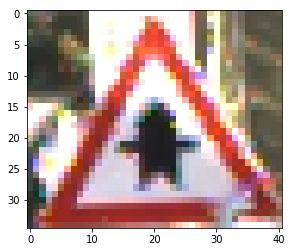

In [191]:
#images1[1].shape
#plt.imshow(images1[1][0:10,10:40]) #image[row_top:row_bottom,col_left:col_right]
image = plt.imread('./FullIJCNN2013/' + '00000.ppm')
dummy = [0,774,411,815,446,11]
top_row = 2
bottom_row = 4
left_col = 1
right_col = 3
plt.imshow(image[dummy[top_row]:dummy[bottom_row],dummy[left_col]:dummy[right_col]])

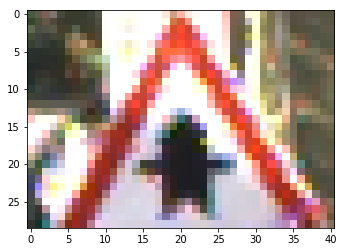

In [194]:
image = image[dummy[top_row]:dummy[bottom_row],dummy[left_col]:dummy[right_col]]
plt.imshow(image[1:30,:]) #proof rows ordered from top to bottom and correspond to x coordinate

In [29]:
distribution = np.array(distribution)
counts = np.array(counts)
required = distribution / counts
per_image = [int(x) for x in required]
print(per_image)
#index_map[13]

[14, 14, 14, 14, 14, 14, 14, 14, 14, 14]


In [198]:
#bounding boxes dimensions
bboxes = [25,30,35,40,50,60,80]

In [30]:
top_row = 1
bottom_row = 3
left_col = 0
right_col = 2

def overlap(instance,top_r,left_c,w,h):
    flag = 0
    #check top left corner of instance
    if instance[top_row] > top_r and instance[top_row] < top_r + h:
        if instance[left_col] > left_c and instance[left_col] < left_c + w:
            flag = 1
            
    #check top right corner of instance
    if instance[top_row] > top_r and instance[top_row] < top_r + h:
        if instance[right_col] > left_c and instance[right_col] < left_c + w:
            flag = 1

    #check bottom left corner of instance
    if instance[bottom_row] > top_r and instance[bottom_row] < top_r + h:
        if instance[left_col] > left_c and instance[left_col] < left_c + w:
            flag = 1
            
    #check bottom right corner of instance
    if instance[bottom_row] > top_r and instance[bottom_row] < top_r + h:
        if instance[right_col] > left_c and instance[right_col] < left_c + w:
            flag = 1
    
    return flag == 1

In [31]:
#get 10,000 easy negatives, hard negatives, and hard positives from GTSDB labeled data 
#use joint distribution of bounding boxes and random areas of free space
easy_neg = []
hard_pos = []
hard_neg = []

easy_neg_label = []
hard_pos_label = []
hard_neg_label = []

top_row = 1
bottom_row = 3
left_col = 0
right_col = 2

current = data[0][0]
single_image = [[int(x) for x in data[0][1:]]]
for i, row in enumerate(data[1:]):
    if i % 10 == 0:
        print(i)
    if current == row[0]:
        single_image.append([int(x) for x in row[1:]])
    else:
        image = plt.imread('./FullIJCNN2013/' + current)
#         for i in range(0,len(single_image)):
#             for j in range(0,len(single_image[0])):
#                 single_image[i][j] = int(single_image[i][j])
        
        #print(single_image)
        for instance in single_image:
            if int(instance[4]) not in topten:
                break
            #print(instance, top_row, bottom_row, left_col, right_col)
            #easy_pos.append(image[instance[top_row]:instance[bottom_row],instance[left_col]:instance[right_col]])
        
            #determine image and sign parameters
            im_bottom = len(image)
            im_right = len(image[0])
            sign_width = instance[right_col] - instance[left_col]
            sign_height = instance[bottom_row] - instance[top_row]
            
            #get as many hard positives as possible (in reality some of these might not be "hard")
            wiggle_room = int(sign_height/6)
            
            #should return up to 16 hard positives (bboxes of similar size as ground truth and barely good overlap)
            for i in range(2):
                flags = []
                #sample two from up shift
                if instance[top_row] - 0 >= wiggle_room: #only collect if enough wiggle room
                    shift_up = np.random.randint(wiggle_room)
                    hard_pos.append(image[(instance[top_row]-shift_up):(instance[bottom_row]-shift_up),instance[left_col]:instance[right_col]])
                    flags.append(1)
                    
                #sample from down shift 
                if im_bottom - instance[bottom_row] >= wiggle_room: #only collect if enough wiggle room
                    shift_down = np.random.randint(wiggle_room)
                    hard_pos.append(image[(instance[top_row]+shift_down):(instance[bottom_row]+shift_down),instance[left_col]:instance[right_col]])
                    flags.append(2)
                    
                #sample from right shift
                if im_right - instance[right_col] >= wiggle_room: #only collect if enough wiggle room
                    shift_right = np.random.randint(wiggle_room)
                    hard_pos.append(image[instance[top_row]:instance[bottom_row],(instance[left_col]+shift_right):(instance[right_col]+shift_right)])
                    flags.append(3)
                    
                #sample from left shift
                if instance[left_col] - 0 >= wiggle_room: #only collect if enough wiggle room
                    shift_left = np.random.randint(wiggle_room)
                    hard_pos.append(image[instance[top_row]:instance[bottom_row],(instance[left_col]-shift_left):(instance[right_col]-shift_left)])
                    flags.append(4)
                    
                #sample two from up-right diagonal
                if 1 in flags and 3 in flags:
                    shift_up = np.random.randint(wiggle_room)
                    shift_right = np.random.randint(wiggle_room)
                    hard_pos.append(image[(instance[top_row]-shift_up):(instance[bottom_row]-shift_up),(instance[left_col]+shift_right):(instance[right_col]+shift_right)])
                    flags.append(5)
                    
                #sample two from up-left diagonal
                if 1 in flags and 4 in flags:
                    shift_up = np.random.randint(wiggle_room)
                    shift_left = np.random.randint(wiggle_room)
                    hard_pos.append(image[(instance[top_row]-shift_up):(instance[bottom_row]-shift_up),(instance[left_col]-shift_left):(instance[right_col]-shift_left)])
                    flags.append(6)
                    
                #sample two from down-right diagonal
                if 2 in flags and 3 in flags:
                    shift_down = np.random.randint(wiggle_room)
                    shift_right = np.random.randint(wiggle_room)
                    hard_pos.append(image[(instance[top_row]+shift_down):(instance[bottom_row]+shift_down),(instance[left_col]+shift_right):(instance[right_col]+shift_right)])
                    flags.append(7)
                    
                #sample two from down-left diagonal
                if 2 in flags and 4 in flags:
                    shift_down = np.random.randint(wiggle_room)
                    shift_left = np.random.randint(wiggle_room)
                    hard_pos.append(image[(instance[top_row]+shift_down):(instance[bottom_row]+shift_down),(instance[left_col]-shift_left):(instance[right_col]-shift_left)])
                    flags.append(8)
                    
                hard_pos_label.extend([int(instance[4])]*len(flags))

            #get as many hard negatives as possible
            min_shift_v = int(2*sign_height/5)
            min_shift_h = int(2*sign_width/5)
            
            wiggle_top = min(instance[top_row], int(3*sign_height/4))
            wiggle_bottom = min(im_bottom - instance[bottom_row], int(3*sign_height/4))
            wiggle_right = min(im_right - instance[right_col], int(3*sign_width/4))
            wiggle_left = min(instance[left_col], int(3*sign_width/4))
            
            #should return up to 16 hard negatives (bboxes of similar size as ground truth and almost good overlap)
            for i in range(2):
                flags = []
                #sample two from up shift
                if wiggle_top >= min_shift_v: #only collect if at least min_shift wiggle room
                    shift_up = np.random.randint(min_shift_v, wiggle_top)
                    hard_neg.append(image[(instance[top_row]-shift_up):(instance[bottom_row]-shift_up),instance[left_col]:instance[right_col]])
                    flags.append(1)
                    
                #sample from down shift 
                if wiggle_bottom >= min_shift_v: #only collect if at least min_shift wiggle room
                    shift_down = np.random.randint(min_shift_v, wiggle_bottom)
                    hard_neg.append(image[(instance[top_row]+shift_down):(instance[bottom_row]+shift_down),instance[left_col]:instance[right_col]])
                    flags.append(2)
                    
                #sample from right shift
                if wiggle_right >= min_shift_h: #only collect if at least min_shift wiggle room
                    shift_right = np.random.randint(min_shift_h, wiggle_right)
                    hard_neg.append(image[instance[top_row]:instance[bottom_row],(instance[left_col]+shift_right):(instance[right_col]+shift_right)])
                    flags.append(3)
                    
                #sample from left shift
                if wiggle_left >= min_shift_h: #only collect if at least min_shift wiggle room
                    shift_left = np.random.randint(min_shift_h, wiggle_left)
                    hard_neg.append(image[instance[top_row]:instance[bottom_row],(instance[left_col]-shift_left):(instance[right_col]-shift_left)])
                    flags.append(4)
                    
                #sample two from up-right diagonal
                if 1 in flags and 3 in flags:
                    shift_up = np.random.randint(min_shift_v, wiggle_top)
                    shift_right = np.random.randint(min_shift_h, wiggle_right)
                    hard_neg.append(image[(instance[top_row]-shift_up):(instance[bottom_row]-shift_up),(instance[left_col]+shift_right):(instance[right_col]+shift_right)])
                    flags.append(5)
                    
                #sample two from up-left diagonal
                if 1 in flags and 4 in flags:
                    shift_up = np.random.randint(min_shift_v, wiggle_top)
                    shift_left = np.random.randint(min_shift_h, wiggle_left)
                    hard_neg.append(image[(instance[top_row]-shift_up):(instance[bottom_row]-shift_up),(instance[left_col]-shift_left):(instance[right_col]-shift_left)])
                    flags.append(6)
                    
                #sample two from down-right diagonal
                if 2 in flags and 3 in flags:
                    shift_down = np.random.randint(min_shift_v, wiggle_bottom)
                    shift_right = np.random.randint(min_shift_h, wiggle_right)
                    hard_neg.append(image[(instance[top_row]+shift_down):(instance[bottom_row]+shift_down),(instance[left_col]+shift_right):(instance[right_col]+shift_right)])
                    flags.append(7)
                    
                #sample two from down-left diagonal
                if 2 in flags and 4 in flags:
                    shift_down = np.random.randint(min_shift_v, wiggle_bottom)
                    shift_left = np.random.randint(min_shift_h, wiggle_left)
                    hard_neg.append(image[(instance[top_row]+shift_down):(instance[bottom_row]+shift_down),(instance[left_col]-shift_left):(instance[right_col]-shift_left)])
                    flags.append(8)
                    
                hard_neg_label.extend([int(instance[4])]*len(flags))
        
            #get easy negatives - need 14 per instance
            for i in range(0,14):
                #sample a bounding box size from known distribution
                while(True):
                    string = np.random.choice(sizes, p=probs)
                    [w,h] = [int(x) for x in string.split(":")]
                    top_r = np.random.randint(0,im_bottom - h)
                    left_c = np.random.randint(0,im_right - w)

                    if (overlap(instance,top_r,left_c,w,h)):
                        continue
                    else:
                        easy_neg.append(image[top_r:(top_r+h),left_c:(left_c+w)])
                        easy_neg_label.append(0)
                        break
                
        current = row[0]
        single_image = [[int(x) for x in row[1:]]]


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210


In [32]:
print('positives')
print(len(easy_pos))
print(len(hard_pos))

print('\nnegatives')
print(len(easy_neg))
print(len(hard_neg))

positives
9995
8976

negatives
7854
8940


9


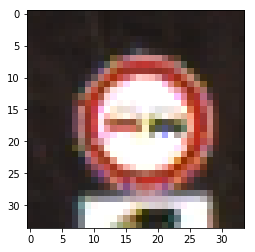

In [33]:
n = 9887
print(easy_pos_label[n])
plt.imshow(easy_pos[n])

255
0
1
0


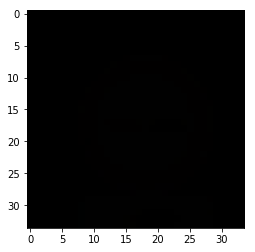

In [35]:
img = easy_pos[n]
print(np.max(img))
print(np.min(img))
norm_image = img.copy()
cv2.normalize(img, norm_image, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=-1)
plt.imshow(norm_image)
print(np.max(norm_image))
print(np.min(norm_image))

0.3586980120768031
1.0
0.0


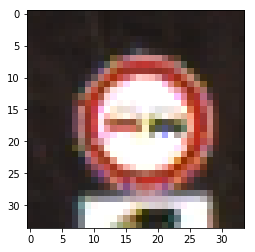

In [36]:
norm_image = img.copy()
norm_image = norm_image / np.max(img)
plt.imshow(norm_image)
print(np.mean(norm_image))
print(np.max(norm_image))
print(np.min(norm_image))

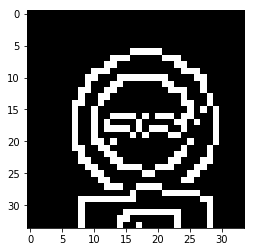

In [39]:
edges = cv2.Canny(img,100,200)
plt.imshow(edges,cmap = 'gray')

In [40]:
print(np.unique(np.array(easy_pos_label)))
print(np.unique(np.array(hard_pos_label)))
print(sorted(topten))

[ 1  2  4  5  9 10 12 13 25 38]
[ 1  2  4  5  9 10 12 13 25 38]
[1, 2, 4, 5, 9, 10, 12, 13, 25, 38]


In [41]:
#Save all fine data to memory
np.savez('/tmp/distribution_data', easy_pos=easy_pos, hard_pos=hard_pos, 
         easy_pos_label=easy_pos_label, hard_pos_label=hard_pos_label, easy_neg=easy_neg,
        hard_neg=hard_neg,easy_neg_label=easy_neg_label,hard_neg_label=hard_neg_label)

In [ ]:
# #load above files from memory
# loaded = np.load('/tmp/distribution_data.npz')
# easy_pos = loaded['easy_pos']
# hard_pos=loaded['hard_pos']
# easy_pos_label=loaded['easy_pos_label']
# hard_pos_label=loaded['hard_pos_label']
# easy_neg=loaded['easy_neg']
# hard_neg=loaded['hard_neg']
# easy_neg_label=loaded['easy_neg_label']
# hard_neg_label=loaded['hard_neg_label']

In [145]:
#combine all positives
positives = []
positives.extend(easy_pos)
positives.extend(hard_pos)
pos_label = []
pos_label.extend(easy_pos_label)
pos_label.extend(hard_pos_label)
print(len(positives))
print(len(pos_label))

#combine all negatives
negatives = []
negatives.extend(easy_neg)
negatives.extend(hard_neg)
neg_label = []
neg_label.extend(easy_neg_label)
neg_label.extend(hard_neg_label)
print(len(negatives))
print(len(neg_label))

18971
18971
16794
16794


In [146]:
# -> All images were scaled to 40x40 pixels using bilinear interpolation
for i in range(0,len(positives)):
    positives[i] = cv2.resize(positives[i], (40, 40)) 

for i in range(0, len(negatives)):
    negatives[i] = cv2.resize(negatives[i], (40, 40))

In [135]:
# -> Cell size 5x5 pixels (cellsize_x = 5, cellsize_y = 5)
# -> Block size 2x2 cells (numcell_x= 2, numcell_y = 2)
# -> Blocks shifted by 5 pixels in both directions (descstride_x = 5, descstride_y = 5)
# -> 8 orientations (orientbin = 8)
# -> semiCirc = true
# -> Preprocessor: RGB_Sqrt_Grad
# -> Normalizer: NormL2Hys

winSize = (40,40)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (5,5)
nbins = 8
derivAperture = 1
winSigma = 4. #Gaussian smoothing window parameter
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 32
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
#winStride=(0,0)
# padding=(8,8)
# locations=((10,10),(10,30),(30,10),(30,30))
# hist = hog.compute(image,winStride,padding,locations)
# hist = hog.compute(img, winStride=winStride)

In [136]:
hist = hog.compute(positives[0], winStride=winStride)
len(hist)

1568

In [ ]:
###DATA FOR SIGN RECOGNITION BY SVM 

In [137]:
def convert(sample):
    return np.array([sample[:,:,0],sample[:,:,1],sample[:,:,2]])

In [142]:
# #extract HoGs for all positive samples, HoG fd of length 2916

hog_pos_label = pos_label.copy()
hog_positives = []
for sample in positives:
    hog_positives.append(hog.compute(sample))
    
#shuffle the result
hog_positives = np.array(hog_positives)
hog_pos_label = np.array(hog_pos_label)
indexes = [i for i in range(0,len(hog_positives))]
np.random.shuffle(indexes)
hog_positives = hog_positives[indexes]
hog_pos_label = hog_pos_label[indexes]

#15000 for train, rest for test ~4,000
hog_pos_train = hog_positives[:15000]
hog_pos_train_label = hog_pos_label[:15000]
hog_pos_test = hog_positives[15000:]
hog_pos_test_label = hog_pos_label[15000:]

print(len(hog_pos_train))
print(len(hog_pos_test))
print(hog_pos_train[0].shape)

15000
3971
(1568, 1)


In [140]:
hog_positives[0]

array([[0.0734295 ],
       [0.07081682],
       [0.030188  ],
       ...,
       [0.        ],
       [0.        ],
       [0.00454998]], dtype=float32)

In [143]:
## Run SVM Classifier for Classification on HoG
np.savez('/tmp/ml_classification', hog_pos_train=hog_pos_train, hog_pos_train_label=hog_pos_train_label,
        hog_pos_test=hog_pos_test, hog_pos_test_label=hog_pos_test_label)

In [ ]:
###DATA FOR SIGN DETECTION BY SVM

In [152]:
#extract HoGs for all positive and negative samples, HoG fd of length 2916
total_hog = positives.copy()
total_hog.extend(negatives)
total_labels = [1]*len(positives)
total_labels.extend([0]*len(negatives))
print(len(total_hog))
print(len(total_labels))
print(len(negatives)+len(positives))

35765
35765
35765


In [153]:
#extract HoGs for all samples
all_ = []
for sample in total_hog:
    all_.append(hog.compute(sample))
    
#shuffle the result
all_ = np.array(all_)
total_labels = np.array(total_labels)
indexes = [i for i in range(0,len(all_))]
np.random.shuffle(indexes)
total_hog = all_[indexes]
total_labels = total_labels[indexes]

#25000 for train, 8000 for test (throw out rest)
total_hog_train = total_hog[:25000]
total_hog_train_labels = total_labels[:25000]
total_hog_test = total_hog[25000:33000]
total_hog_test_labels = total_labels[25000:33000]

print(len(total_hog_train))
print(len(total_hog_test))
print(total_hog_train[0].shape)

25000
8000
(1568, 1)


In [154]:
##Run SVM Classifier for Dectection on HoG
np.savez('/tmp/ml_detection', total_hog_train=total_hog_train, 
         total_hog_train_labels=total_hog_train_labels, total_hog_test=total_hog_test,
        total_hog_test_labels=total_hog_test_labels)

In [ ]:
###ALTERNATIVE IMPLEMENTATION OF HOG JUST IN CASE

In [98]:
all_ = convert(img)
r = all_[0]
g = all_[1]
b = all_[2]

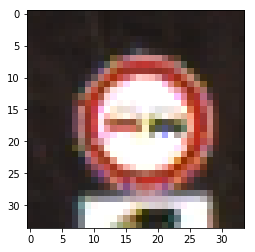

In [108]:
plt.imshow(img)

In [120]:
fd_r, visual_r = skimage.feature.hog(r, orientations=8, pixels_per_cell=(5, 5),
                    cells_per_block=(2, 2), block_norm=('L2-Hys'), visualise=True, transform_sqrt=True,
                         feature_vector=True)

fd_g, visual_g = skimage.feature.hog(g, orientations=8, pixels_per_cell=(5, 5),
                    cells_per_block=(2, 2), block_norm=('L2-Hys'), visualise=True, transform_sqrt=True,
                         feature_vector=True)

fd_b, visual_b = skimage.feature.hog(b, orientations=8, pixels_per_cell=(5, 5),
                    cells_per_block=(2, 2), block_norm=('L2-Hys'), visualise=True, transform_sqrt=True,
                         feature_vector=True)

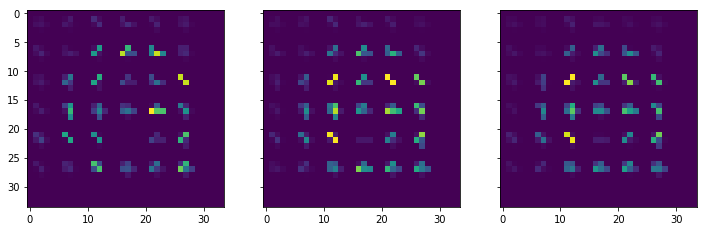

In [121]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax1.imshow(visual_r)
ax2.imshow(visual_g)
ax3.imshow(visual_b)

(800,)
(34, 34)


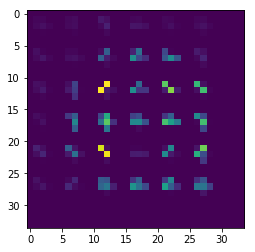

In [110]:
#to combine results must take maximum gradient at each pixel across all colors
fd = np.maximum(np.maximum(fd_r,fd_g), fd_b)

In [158]:
##DATA FOR SIGN RECOGNITION BY CNN

In [155]:
##pickle data for LeNet5 CNN
labels = [1]*len(positives)
labels.extend([0]*len(negatives))
data = positives
data.extend(negatives)
print(len(data),len(labels))

22420 22420


In [156]:
data[0].shape

(40, 40, 3)

In [158]:
data = np.array(data)
data.shape

(22420, 40, 40, 3)

In [159]:
labels = np.array(labels)
labels.shape

(22420,)

In [160]:
np.savez('/tmp/train_data', data=data, labels=labels)

In [445]:
positives = []

In [466]:
#scale images to 0-1 rgb range
for i in range(len(positives)):
    positives[i] = positives[i] / np.max(positives[i])

0.26409031413612566


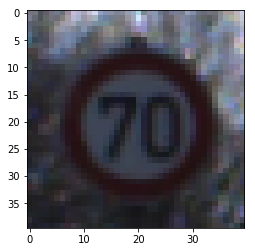

In [475]:
print(np.mean(positives[7734]))
plt.imshow(positives[7734])

In [470]:
##save data for LeNet5 CNN
np.savez('/tmp/classification', positives=positives, pos_label=pos_label)

In [ ]:
##DATA FOR SIGN DETECTION BY CNN

In [318]:
#group all positive and negative sample, into one training set for LeNet Detection
total = positives.copy()
total.extend(negatives)
labels = [1]*len(positives)
labels.extend([0]*len(negatives))
print(len(total))
print(len(labels))
print(len(negatives)+len(positives))

35765
35765
35765


In [319]:
#shuffle the samples
total = np.array(total)
labels = np.array(labels)
indexes = [i for i in range(0,len(total))]
np.random.shuffle(indexes)
total = total[indexes]
labels = labels[indexes]

In [320]:
print(np.max(np.max(total)))
print(np.min(np.min(total)))
print(total[0].shape)
print(type(total[0]))

255
0
(40, 40, 3)
<class 'numpy.ndarray'>


In [314]:
import numpy.ma as ma

In [322]:
#CNN train better if you scale images to 0-1 rgb range
for i in range(len(total)):
    #total[i] = ma.log(total[i]).filled(0)
    total[i] = total[i] / np.mean(total[i])

In [332]:
# n = np.random.randint(len(total))
# print(labels[n])
# plt.imshow(total[n])

In [327]:
#Input to CNN needs to be in converted form
new_total = []
for i in range(len(total)):
    new_total.append(convert(total[i]))
total = new_total

In [329]:
print(np.max(np.max(total)))
print(np.min(np.min(total)))
total[0].shape

17
0


(3, 40, 40)

In [330]:
##save data for LeNet5 CNN
np.savez('/tmp/dl_detection', total=total, labels=labels)

In [334]:
dumdum = np.array([81, 79, 83, 85, 88, 80, 68, 53, 31, 41])
dumdum = dumdum / np.sum(dumdum)
dumdum

array([0.11756168, 0.11465893, 0.12046444, 0.1233672 , 0.12772134,
       0.1161103 , 0.09869376, 0.07692308, 0.04499274, 0.05950653])